In [1]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
# print the JS visualization code to the notebook
shap.initjs()

### prepossing

In [2]:
cs=pd.read_csv('/data/embedding/new_data_dblp.csv')

In [13]:
c5_mean=cs['citation5'].mean()

In [14]:
cs['citation5_True']=cs['citation5'].apply(lambda x: True if x>=c5_mean else False)

In [15]:
Counter(cs['citation5_True'])

Counter({False: 2872227, True: 785900})

In [16]:
cs['author_gender_inferred_by_demographicx']=cs['author_gender_inferred_by_demographicx'].apply(lambda x: eval(x))
cs['author_ethnicity_inferred_by_demographicx']=cs['author_ethnicity_inferred_by_demographicx'].apply(lambda x: eval(x))                                                                                           

In [17]:
cs['ethnicity']=cs['author_ethnicity_inferred_by_demographicx'].apply(lambda x: len(set(x)))

In [18]:
def gender_c (x):
    a=[i for i in x if i!='unknown']
    f=len([i for i in a if i=='female'])
    m=len([i for i in a if i=='male'])
    if f>m:
        return 'female-dominated'
    if f<m:
        return 'male-dominated'
    if f==m>0:
        return 'equal'
    if f==m==0:
        return 'unknown'

In [19]:
cs['gender_c']=cs['author_gender_inferred_by_demographicx'].apply(lambda x: gender_c(x))

In [20]:
def gender_n(x):
    if x=='male-dominated':
        return 1
    if x=='equal':
        return 2
    if x=='female-dominated':
        return 3
    if x=='unknown':
        return 4

In [21]:
cs['gender_n']=cs['gender_c'].apply(lambda x: gender_n(x))

In [22]:
Counter(cs['gender_n'])

Counter({1: 2093355, 4: 984912, 2: 298749, 3: 281111})

In [23]:
cs=cs[cs['gender_n']!=4]

In [24]:
# def ind_aca_n(x):
#     if x == 'edu': # all universities
#         return 1
#     if x == 'com': # all companies
#         return 2
#     if x == 'comb': # have both universities and companies
#         return 3
#     if x == 'else': 
#         return 4

In [25]:
cs=cs[cs['ind_aca_n']!=4]

In [26]:
len(cs)

1675035

In [27]:
Counter(cs['citation5_True'])

Counter({False: 1263162, True: 411873})

In [28]:
cs.head(1)

,tid,p_year,n_citation,aid,aname,aorg,references,aid_nan,len,sci_age,...,co_Gini_p,logcitation2,logcitation5,ind_aca_n,gender_n,author_ethnicity_inferred_by_demographicx,author_gender_inferred_by_demographicx,citation5_True,ethnicity,gender_c
0,1091,2013,1,"[2312688602, 2482909946, 2128134587, 210178269...","['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...","['Shinshu University', 'Shinshu University', '...","[2005687710, 2018037215]",0.0,8.0,"[1, 1, 16, 20, 20, 6, 17, 13]",...,3,0.0,0.0,1,1,"[asian, asian, asian, asian, asian, asian, asi...","[male, unknown, female, male, male, male, male...",False,1,male-dominated


In [29]:
allteams=pd.read_csv('/home/yb4635/sharedleadership/allteams.csv')

In [32]:
allteams['individual_citation']=allteams['individual_citation'].apply(lambda x: eval(x) if x==x else np.nan)

In [33]:
W_citation={}
for i,j in zip(allteams['tid'],allteams['individual_citation']):
    W_citation[i]=j

In [34]:
cs['individual_citation']=cs['tid'].apply(lambda x: W_citation[x])

In [35]:
allteams['hindex']=allteams['hindex'].apply(lambda x: eval(x) if x==x else np.nan)

In [36]:
W_hindex={}
for i,j in zip(allteams['tid'],allteams['hindex']):
    W_hindex[i]=j

In [37]:
cs['hindex']=cs['tid'].apply(lambda x: W_hindex[x])

In [15]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [39]:
cs['citation_mean']=cs['individual_citation'].apply(lambda x: np.mean(x))

In [40]:
cs['citation_gini']=cs['individual_citation'].apply(lambda x: gini(x))

In [41]:
cs['hindex_mean']=cs['hindex'].apply(lambda x: np.mean(x))

In [42]:
cs['hindex_gini']=cs['hindex'].apply(lambda x: gini(x))

In [53]:
cs.to_csv('/data/embedding/new.csv',index=False)

In [2]:
cs=pd.read_csv('/data/embedding/new.csv')

In [80]:
cs.rename(columns = {'Ins_country_num':'Country Number', 'len':'Team Size',
                    'ethnicity':'Ethnicity Number'}, 
          inplace = True)

In [81]:
cs.rename(columns = {'Mean_power':'Mean Career Age', 'Gini':'Gini Career Age',
                    'ind_aca_n':'Education/Company', 'gender_c':'Male/Female',
                    'co_Gini':'Gini Collaborator', 'co_Mean':'Mean Collaborator',
                    'pro_Gini':'Gini Productivity', 'pro_Mean':'Mean Productivity',
                    'citation_mean':'Mean Citation', 'citation_gini':'Gini Citation',
                    'hindex_mean':'Mean Hindex', 'hindex_gini':'Gini Hindex',}, 
          inplace = True)

In [82]:
cs.rename(columns = {'citation5_True':'True/False'}, 
          inplace = True)
cs.rename(columns = {'gender_n':'Male/Female Category',
                    'ind_aca':'Education/Company Category'}, 
          inplace = True)

In [91]:
cs.to_csv('/data/embedding/new.csv',index=False)

In [2]:
cs=pd.read_csv('/data/embedding/new.csv')

In [4]:
allteams=pd.read_csv('/home/yb4635/sharedleadership/allteams.csv')

In [5]:
allteams['individual_citation']=allteams['individual_citation'].apply(lambda x: eval(x) if x==x else np.nan)

In [6]:
W_citation={}
for i,j in zip(allteams['tid'],allteams['individual_citation']):
    W_citation[i]=j

In [7]:
cs['individual_citation']=cs['tid'].apply(lambda x: W_citation[x])   

In [8]:
allteams['productivity']=allteams['productivity'].apply(lambda x: eval(x) if x==x else np.nan)

In [9]:
W_productivity={}
for i,j in zip(allteams['tid'],allteams['productivity']):
    W_productivity[i]=j

In [10]:
cs['productivity']=cs['tid'].apply(lambda x: W_productivity[x])   

In [11]:
allteams['hindex']=allteams['hindex'].apply(lambda x: eval(x) if x==x else np.nan)

In [12]:
W_hindex={}
for i,j in zip(allteams['tid'],allteams['hindex']):
    W_hindex[i]=j

In [13]:
cs['hindex']=cs['tid'].apply(lambda x: W_hindex[x])   

In [14]:
cs['Mean Citation']=cs['individual_citation'].apply(lambda x: np.mean(x))

In [16]:
cs['Gini Citation']=cs['individual_citation'].apply(lambda x: gini(x))

In [17]:
cs['Mean Hindex']=cs['hindex'].apply(lambda x: np.mean(x))

In [18]:
cs['Gini Hindex']=cs['hindex'].apply(lambda x: gini(x))

In [19]:
cs['Mean Productivity']=cs['productivity'].apply(lambda x: np.mean(x))

In [20]:
cs['Gini Productivity']=cs['productivity'].apply(lambda x: gini(x))

In [21]:
cs.to_csv('/data/embedding/new.csv',index=False)

##### starting

In [2]:
cs=pd.read_csv('/data/embedding/new.csv')

In [3]:
cs['True/False']=cs['True/False'].apply(lambda x: 1 if x==True else 0)

In [4]:
cs['Gini Hindex'] = cs['Gini Hindex'].fillna(0)
cs['Gini Citation'] = cs['Gini Citation'].fillna(0)

In [5]:
# X = cs[['Country Number','Team Size','Ethnicity Number','Mean Career Age','Gini Career Age','Education/Company','Male/Female','Gini Collaborator', 'Mean Collaborator','Gini Productivity', 'Mean Productivity','Mean Citation','Gini Citation','Mean Hindex','Gini Hindex']]
X = cs[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]

In [6]:
y = cs['True/False']

In [7]:
# X_display = cs[['Country Number','Team Size','Ethnicity Number','Mean Career Age','Gini Career Age','Education/Company','Male/Female','Gini Collaborator', 'Mean Collaborator','Gini Productivity', 'Mean Productivity','Mean Citation','Gini Citation','Mean Hindex','Gini Hindex']]
X_display = cs[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]

In [8]:
y_display = cs['True/False']

In [9]:
train_=cs.sample(frac=0.80,random_state=4)

In [10]:
#downsampling
# _=train_[train_['citation5_True']==False].sample(len(train_[train_['citation5_True']==True]),random_state=4)
# train=_.append(train_[train_['citation5_True']==True])

In [11]:
#upsampling
a=train_[train_['True/False']==True]

In [12]:
_=pd.DataFrame()
for i in range(101):
    _=_.append(a.sample(10000))
train=_.append(train_[train_['True/False']==False])

In [13]:
test=cs[~cs['tid'].isin(train_['tid'].values)]

In [14]:
X_train=train[['Country Number','Team Size','Ethnicity Number','Mean Career Age','Gini Career Age','Education/Company','Male/Female','Gini Collaborator', 'Mean Collaborator','Gini Productivity', 'Mean Productivity','Mean Citation','Gini Citation','Mean Hindex','Gini Hindex']]
X_test=test[['Country Number','Team Size','Ethnicity Number','Mean Career Age','Gini Career Age','Education/Company','Male/Female','Gini Collaborator', 'Mean Collaborator','Gini Productivity', 'Mean Productivity','Mean Citation','Gini Citation','Mean Hindex','Gini Hindex']]
y_train=train['True/False']
y_test=test['True/False']

In [15]:
Counter(y_train),Counter(y_test)

(Counter({1: 1010000, 0: 1010300}), Counter({0: 252862, 1: 82145}))

In [16]:
# create a train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [17]:
len(X_train),len(X_test)

(2020300, 335007)

In [18]:
X=X_train.append(X_test)

In [19]:
y=y_train.append(y_test)

In [20]:
len(X_train),len(X_test),len(X)

(2020300, 335007, 2355307)

In [21]:
model_ = xgboost.XGBClassifier(eta=0.01,
    objective= "binary:logistic",
    subsample=0.8,
    base_score=np.mean(y_train),
    max_depth=20,
    min_child_weight=5,
    gamma=3,
    n_estimators=100,
    colsample_bytree=0.9,
    scale_pos_weight=1,
    reg_alpha=0.3)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_.fit(X_train, y_train.values.ravel(), early_stopping_rounds=100, eval_metric=["auc",'error'], eval_set=eval_set, verbose=100)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.80797	validation_0-error:0.26666	validation_1-auc:0.64076	validation_1-error:0.35714
[99]	validation_0-auc:0.92269	validation_0-error:0.14461	validation_1-auc:0.70803	validation_1-error:0.29552


XGBClassifier(base_score=0.4999257536009504, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False, eta=0.01,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.3, ...)

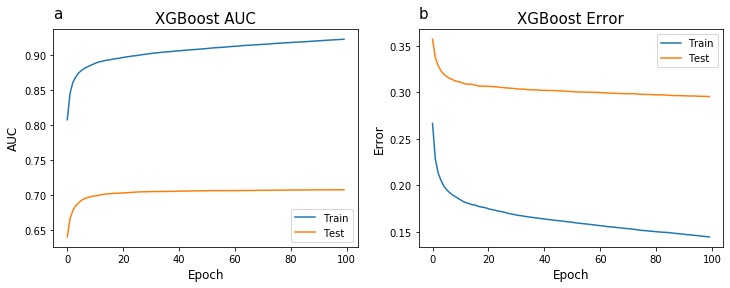

In [136]:
# retrieve performance metrics
results = model_.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig=plt.figure(figsize=(12, 4),facecolor = 'white')
ax = fig.add_subplot(121)
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1.05
plt.text(ax.get_xlim()[0],b,'a',fontsize=15)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('AUC',fontsize=12)
plt.title('XGBoost AUC',fontsize=15)
# plot classification error
ax = fig.add_subplot(122)
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.title('XGBoost Error',fontsize=15)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1.05
plt.text(ax.get_xlim()[0],b,'b',fontsize=15)
plt.show()

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [24]:
# make predictions for test data
y_pred = model_.predict(X_test)
predictions = [round(value) for value in y_pred]

In [25]:
# make predictions for test data
y_pred = model_.predict_proba(X_test)[:, 1]

In [37]:
accuracy

0.7044808018936918

In [26]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.45%


In [27]:
f1 = f1_score(y_test, predictions)
f1

0.46843102828025746

In [28]:
roc_auc_score(y_test, y_pred)

0.7080291618315351

In [29]:
# # save in JSON format
model_.save_model("model_sklearn.json")

In [87]:
# model2 = xgboost.XGBClassifier()
# model2.load_model("model_sklearn.json")

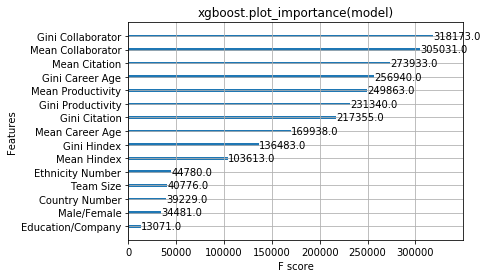

In [30]:
xgboost.plot_importance(model_)
pl.title("xgboost.plot_importance(model)") #the number of times a feature is used to split the data across all trees.
pl.show()

In [31]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model_)

In [32]:
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [54]:
len(shap_values)

335007

In [56]:
len(shap_values[0])

15

In [103]:
shap_values1=[]
for i in shap_values:
    shap_values1.append(list(i[:3])+list(i[5:7])+list(i[-2:]))
shap_values1=np.array(shap_values1)

In [132]:
X_display = cs[['Country Number','Team Size','Ethnicity Number','Mean Career Age','Gini Career Age','Education/Company','Male/Female','Gini Collaborator', 'Mean Collaborator','Gini Productivity', 'Mean Productivity','Mean Citation','Gini Citation','Mean Hindex','Gini Hindex']]

In [104]:
X_display1=X_display[X_display.index.isin(X_test.index)]

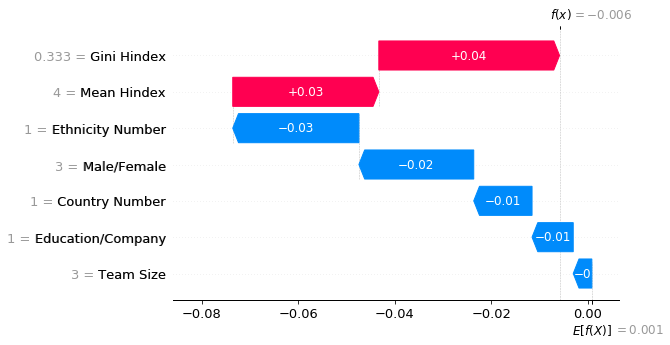

In [105]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values1[0],X_display1.iloc[0],max_display=20)

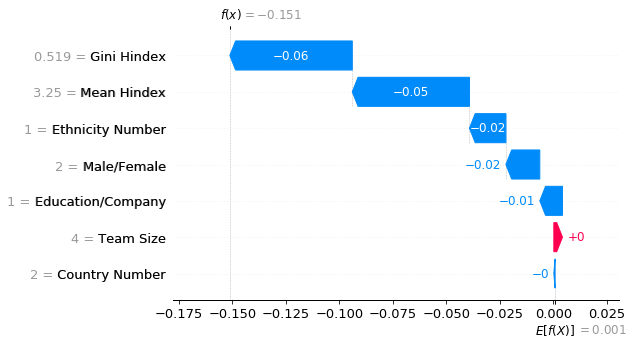

In [106]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values1[1],X_display1.iloc[1],max_display=20)

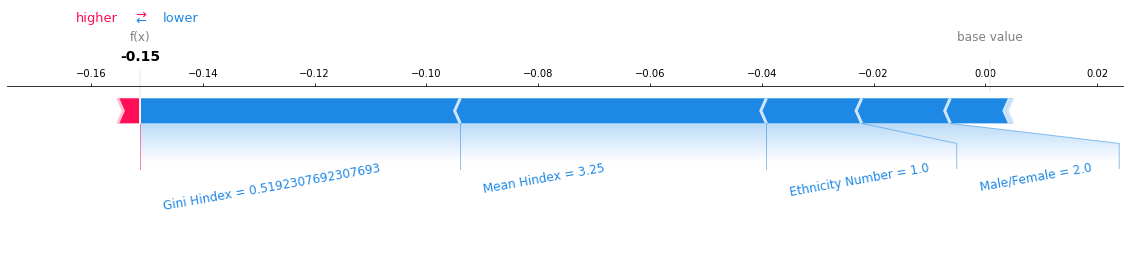

In [107]:
shap.force_plot(explainer.expected_value, shap_values1[1], X_display1.iloc[1],show=False,matplotlib=True,text_rotation=10).savefig('case1.png')

In [72]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_display.iloc[:100,:])

In [131]:
X_display

,Country Number,Team Size,Ethnicity Number,Education/Company,Male/Female,Mean Hindex,Gini Hindex
0,1,8.0,1,1,1,1.375000,0.465909
1,2,4.0,1,1,1,0.000000,0.000000
2,1,3.0,2,1,1,0.000000,0.000000
3,1,2.0,1,1,1,0.000000,0.000000
4,1,4.0,1,1,2,1.500000,0.750000
...,...,...,...,...,...,...,...
1675030,1,3.0,2,1,1,5.333333,0.458333
1675031,2,3.0,1,1,1,17.666667,0.339623
1675032,1,4.0,2,1,1,7.000000,0.339286
1675033,1,4.0,2,1,1,13.500000,0.518519


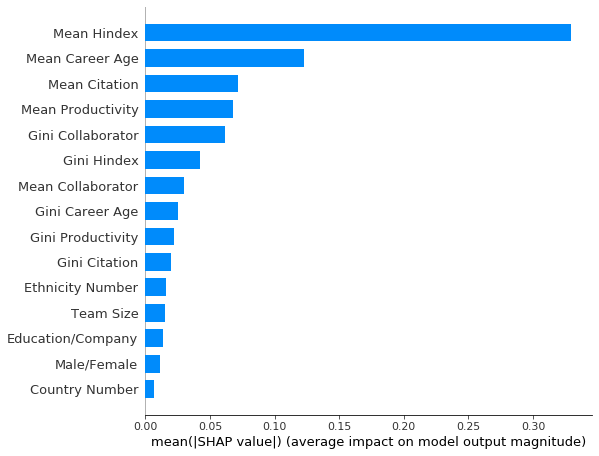

In [133]:
shap.summary_plot(shap_values, X_display, plot_type="bar",show=False)
# plt.tight_layout()
# plt.savefig('summary.png')

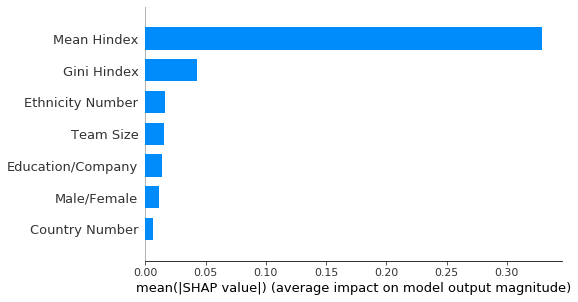

In [110]:
shap.summary_plot(shap_values1, X_display1, plot_type="bar",show=False)
plt.tight_layout()
plt.savefig('summary.png')

In [113]:
X_test1=X_test[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]

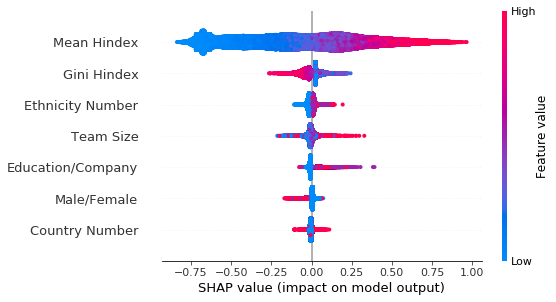

In [114]:
shap.summary_plot(shap_values1, X_test1,show=False)
plt.tight_layout()
plt.savefig('summary_point.png')

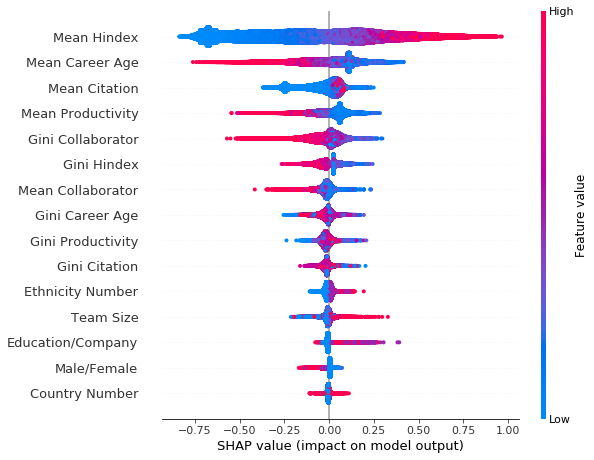

In [134]:
shap.summary_plot(shap_values, X_test,show=False)

In [115]:
# shap_interaction_values = explainer.shap_interaction_values(X_test)

In [116]:
# shap.summary_plot(shap_interaction_values, X_test,text_rotation=10)
# plt.tight_layout()
# plt.savefig('interaction.png')

In [124]:
X_test1.columns

Index(['Country Number', 'Team Size', 'Ethnicity Number', 'Education/Company',
       'Male/Female', 'Mean Hindex', 'Gini Hindex'],
      dtype='object')

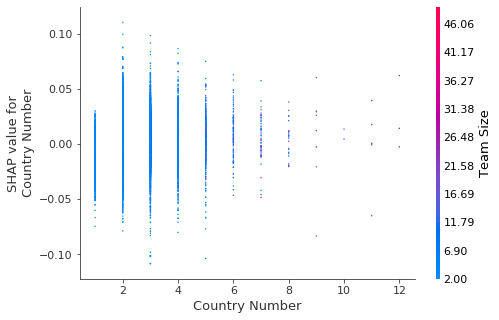

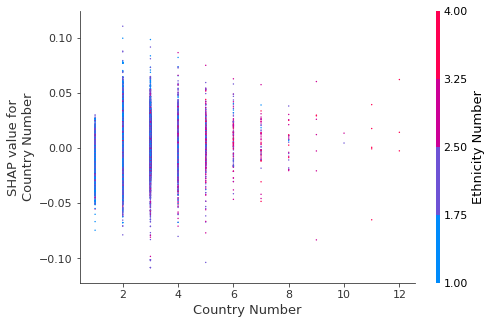

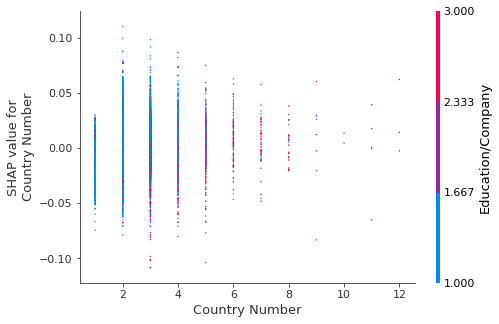

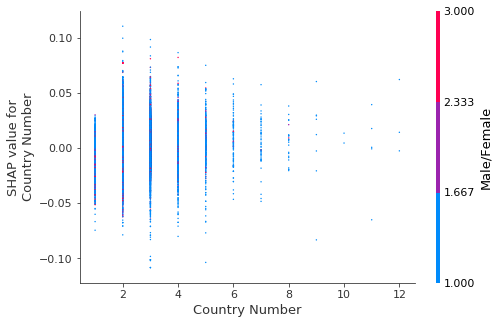

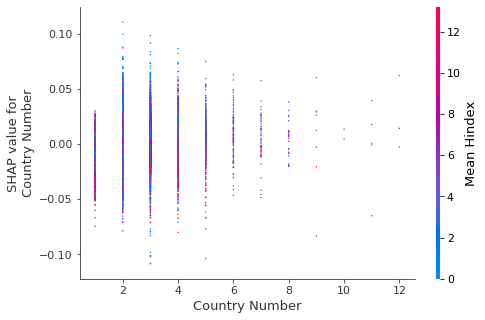

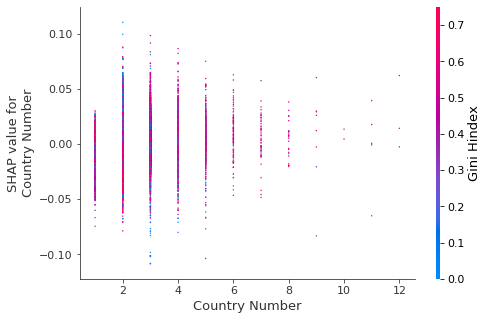

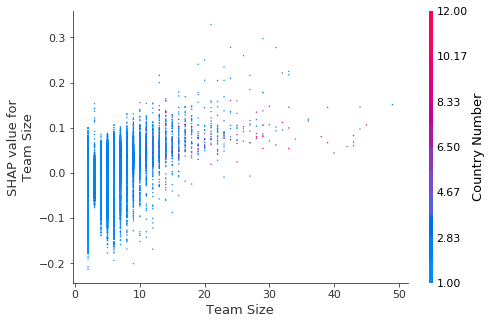

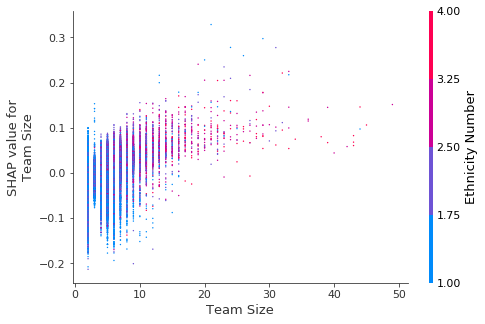

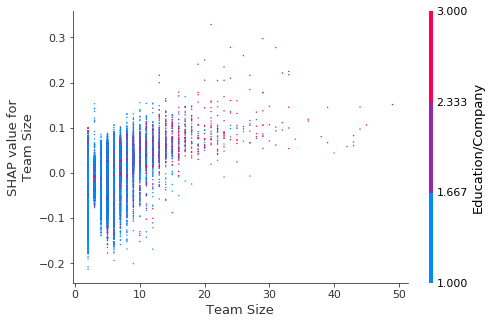

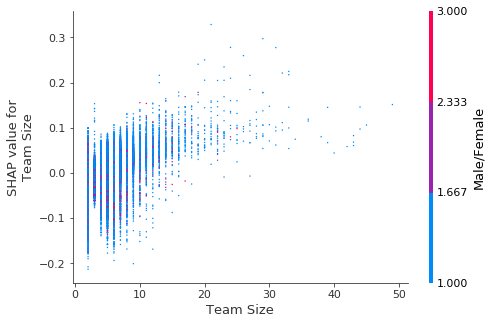

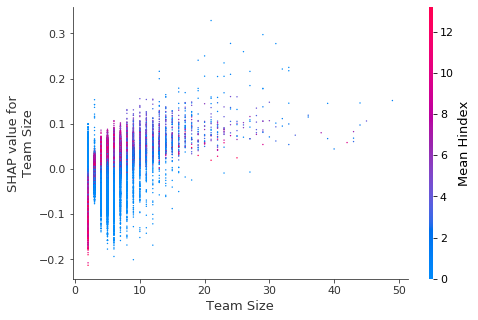

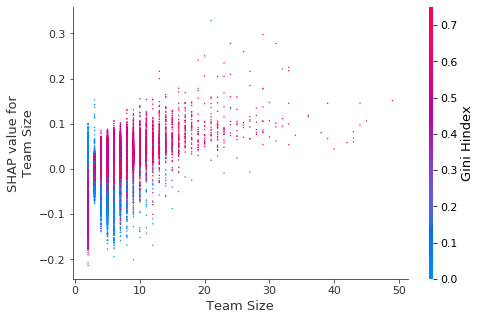

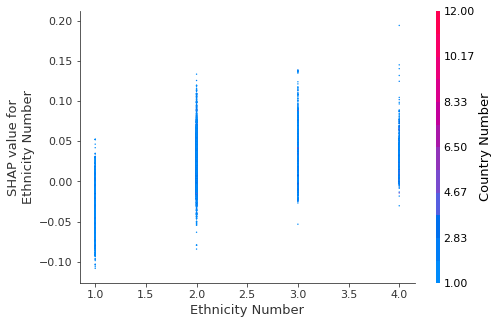

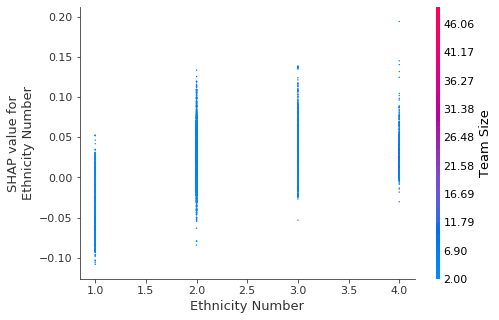

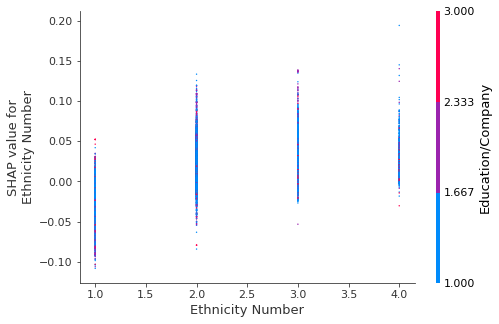

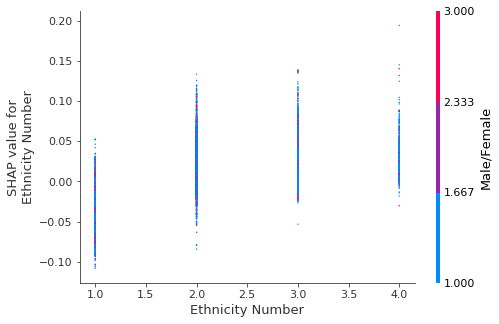

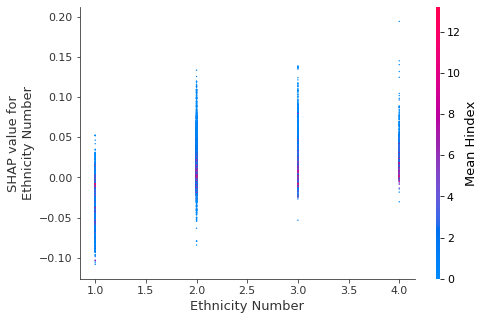

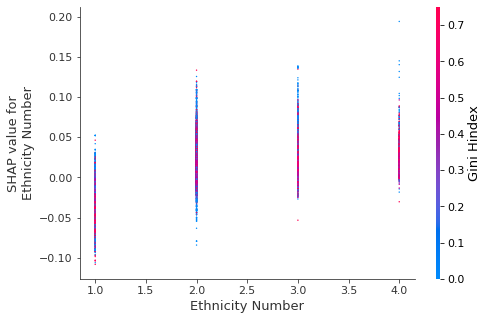

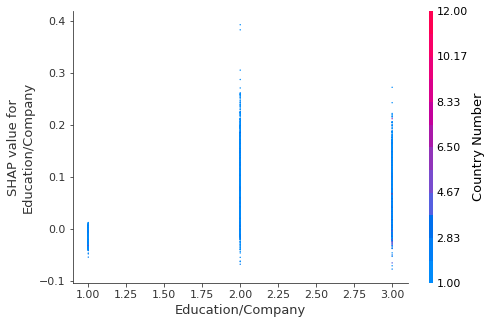

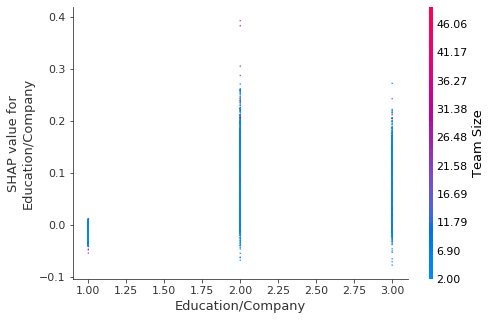

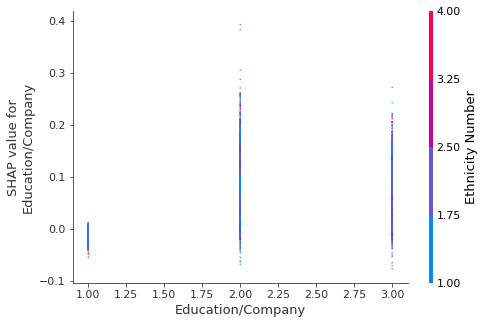

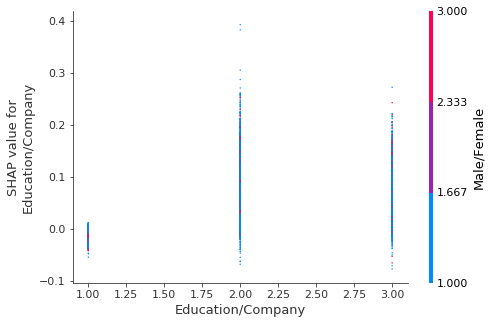

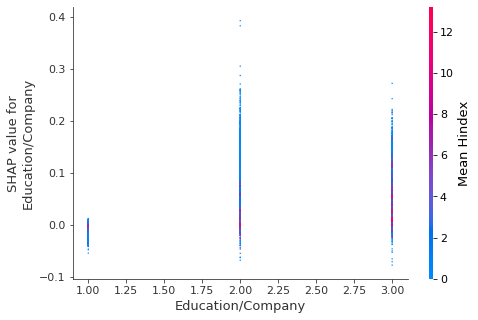

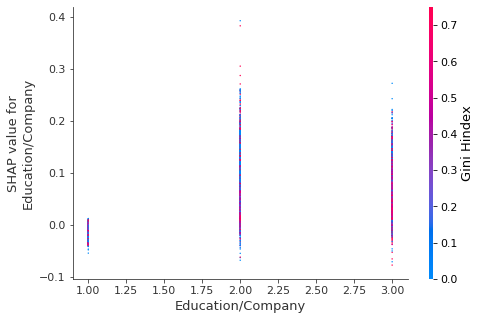

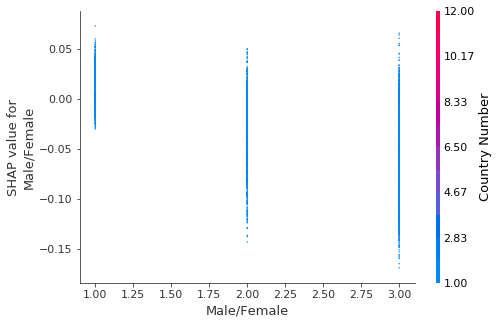

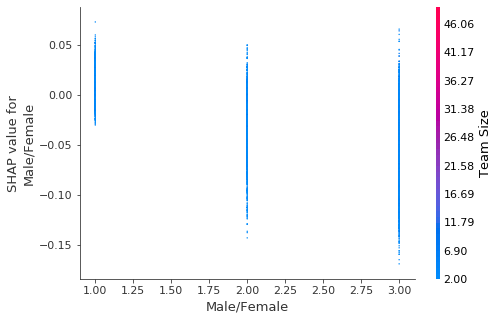

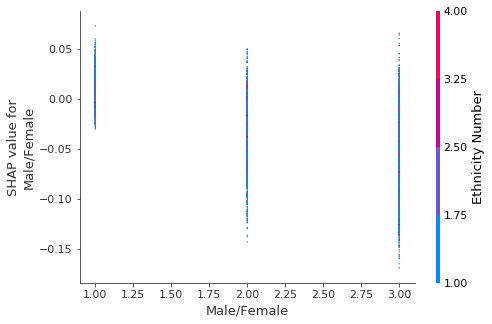

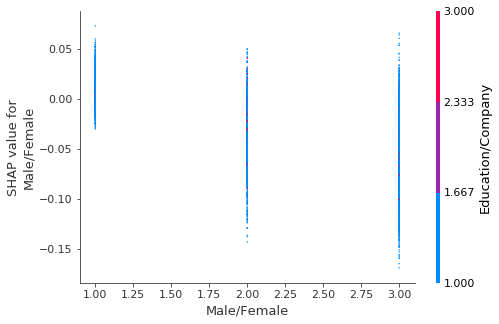

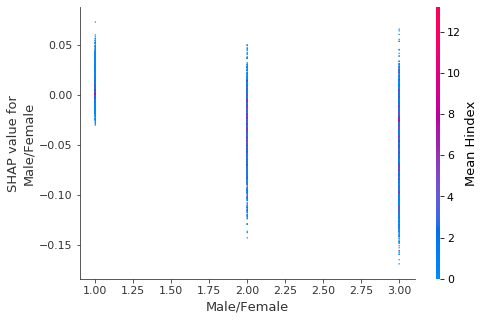

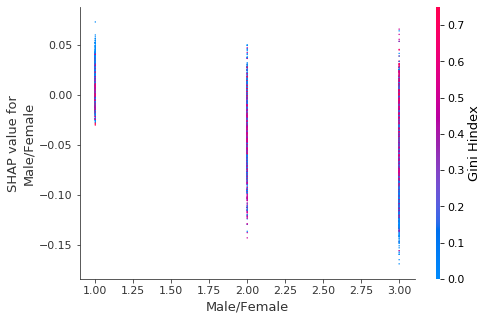

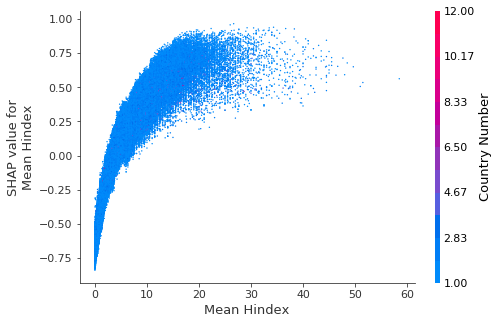

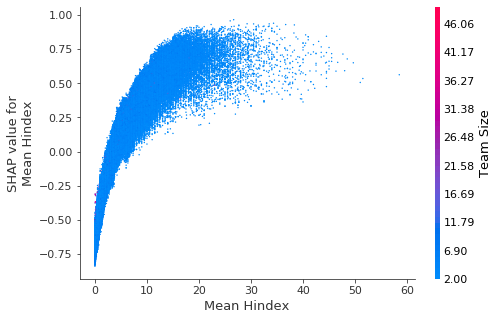

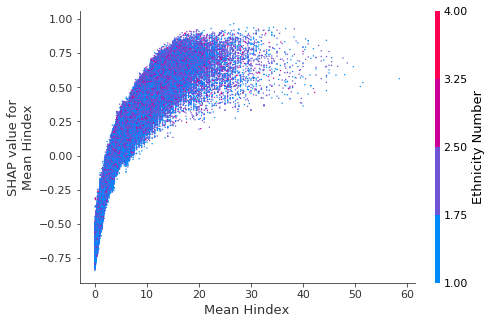

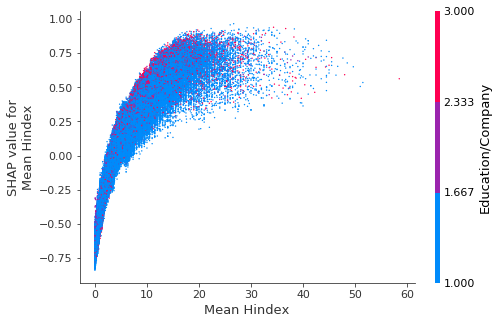

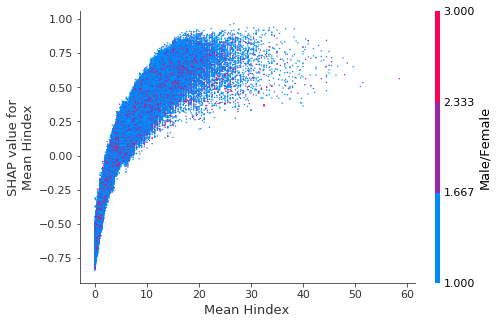

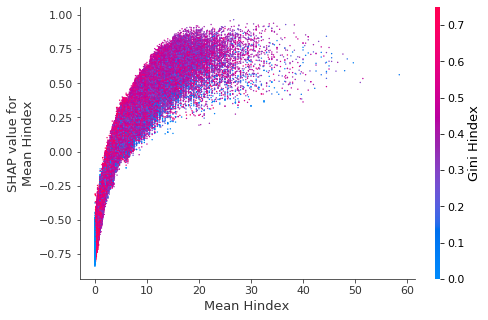

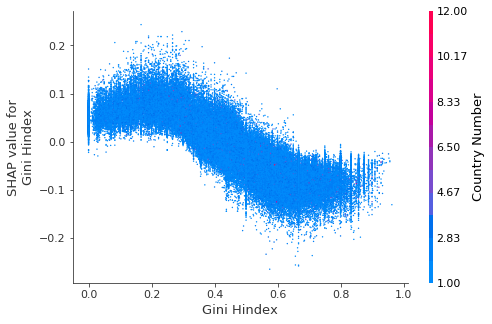

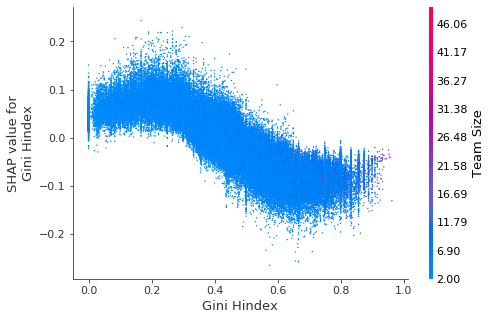

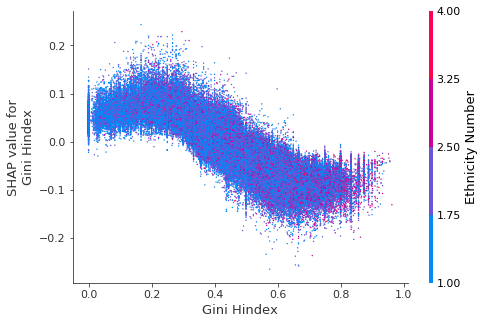

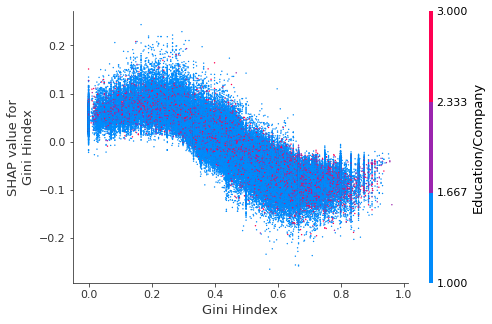

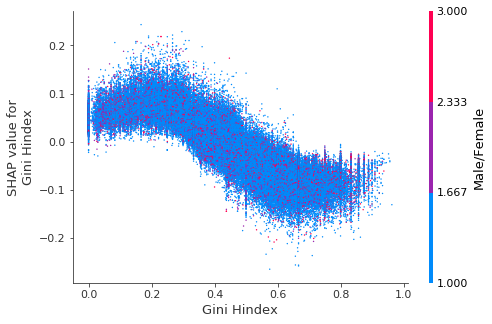

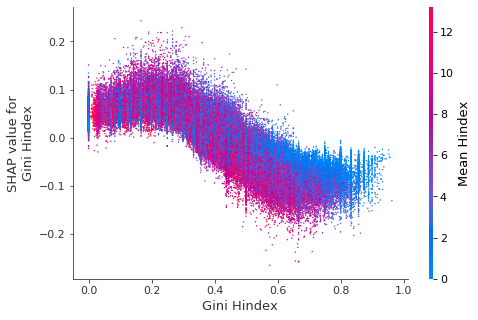

In [127]:
for i in X_test1.columns:
    for j in X_test1.columns:
        if i!=j:
            shap.dependence_plot(i, shap_values1, X_test1, display_features=X_display,interaction_index=j,dot_size=2)

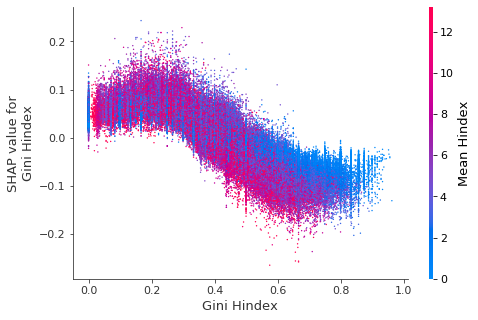

In [141]:
shap.dependence_plot('Gini Hindex', shap_values1, X_test1, display_features=X_display,interaction_index='Mean Hindex',dot_size=2,show=False)

#### seperate h-index

In [91]:
cs=pd.read_csv('/data/embedding/new.csv')

In [92]:
cs['True/False']=cs['True/False'].apply(lambda x: 1 if x==True else 0)

In [93]:
cs['Gini Hindex'] = cs['Gini Hindex'].fillna(0)
cs['Gini Citation'] = cs['Gini Citation'].fillna(0)
cs['Gini Productivity'] = cs['Gini Productivity'].fillna(0)

In [94]:
X = cs[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]

In [95]:
y = cs['True/False']

In [96]:
X_display = cs[['Country Number','Team Size','Ethnicity Number','Education/Company Category','Male/Female Category','Mean Hindex','Gini Hindex']]

In [97]:
y_display = cs['True/False']

In [98]:
train_=cs.sample(frac=0.80,random_state=4)

In [99]:
#upsampling
a=train_[train_['True/False']==True]

In [100]:
_=pd.DataFrame()
for i in range(101):
    _=_.append(a.sample(10000))
train=_.append(train_[train_['True/False']==False])

In [101]:
test=cs[~cs['tid'].isin(train_['tid'].values)]

In [109]:
X_train=train[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]
X_test=test[['Country Number','Team Size','Ethnicity Number','Education/Company','Male/Female','Mean Hindex','Gini Hindex']]
y_train=train['True/False']
y_test=test['True/False']

In [110]:
Counter(y_train),Counter(y_test)

(Counter({1: 1010000, 0: 1010300}), Counter({0: 252862, 1: 82145}))

In [126]:
model_ = xgboost.XGBClassifier(eta=0.3,
    objective= "binary:logistic",
    subsample=0.5,
    base_score=np.mean(y_train),
    max_depth=20,
    min_child_weight=3,
    gamma=3,
    n_estimators=1000,
    colsample_bytree=0.9,
    scale_pos_weight=1,
    reg_alpha=0.3)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_.fit(X_train, y_train.values.ravel(), early_stopping_rounds=1000, eval_metric=['auc'], eval_set=eval_set, verbose=100)

[0]	validation_0-auc:0.66927	validation_1-auc:0.65602
[100]	validation_0-auc:0.73469	validation_1-auc:0.63618
[200]	validation_0-auc:0.74570	validation_1-auc:0.62865
[202]	validation_0-auc:0.74580	validation_1-auc:0.62859


XGBClassifier(base_score=0.4999257536009504, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=5000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.3, ...)

In [127]:
# make predictions for test data
y_pred = model_.predict(X_test)
predictions = [round(value) for value in y_pred]
# make predictions for test data
y_pred = model_.predict_proba(X_test)[:, 1]

In [128]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.76%


In [129]:
f1 = f1_score(y_test, predictions)
f1

0.4378677476737821

In [130]:
roc_auc_score(y_test, y_pred)

0.6569575613056993